In [1]:
import sys
from lsst.daf.butler import Butler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
%load_ext autoreload
%autoreload 2

In [2]:
collection = "u/kmrakovc/runs/single_frame_injection_test_full"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"

240.0

In [3]:
def measure_one_src_catalog(butler, collection, src_ref, calexp_ref, index):
    src = butler.get("src",
                     dataId=src_ref.dataId,
                     collections=collection)
    photocalib = butler.get("calexp.photoCalib",
                            dataId=calexp_ref.dataId,
                            collections=collection)
    wcs = butler.get("calexp.wcs",
                     dataId=calexp_ref.dataId,
                     collections=collection)
    s1 = src[src['parent']==0]
    snr = np.array(s1["base_PsfFlux_instFlux"])/np.array(s1["base_PsfFlux_instFluxErr"])
    magnitude = photocalib.instFluxToMagnitude(s1, 'base_PsfFlux')
    detection_origins = wcs.skyToPixelArray(np.array([s1["coord_ra"]]),
                                            np.array([s1["coord_dec"]]),
                                            degrees=False)
    sources = s1.asAstropy()
    sources["snr"]=snr
    sources["magnitude"]=magnitude[:,0]
    sources["magnitudeErr"]=magnitude[:,1]
    sources["n"]=index
    sources["y"]=np.round(detection_origins[0])
    sources["x"]=np.round(detection_origins[1])
    return sources.to_pandas()

def measure_src_catalog (repo_path, collection, val_index=None, n_parallel=0):
    butler = Butler(repo_path)
    calexp_ref = np.unique(np.array(list(butler.registry.queryDatasets("calexp",
                                                                       collections=collection,
                                                                       instrument='HSC',
                                                                       findFirst=True))))
    src_ref = np.unique(np.array(list(butler.registry.queryDatasets("src",
                                                                    collections=collection,
                                                                    instrument='HSC',
                                                                    findFirst=True))))
    if val_index is None:
        val_index = list(range(len(src_ref)))
    parameters = [(butler, collection, calexp_ref[i], src_ref[i], i) for i in val_index]
    if n_parallel > 1:
        with multiprocessing.Pool(n_parallel) as pool:
            results = pool.starmap(measure_one_src_catalog, parameters)
    else:
        results = [None] * len(parameters)
        for i, p in enumerate(parameters):
            results[i] = measure_one_src_catalog(*p)
            print("\r", i + 1, "/", len(parameters), end="")
    results = pd.concat(results).reset_index(drop=True)
    return results

In [4]:
sources = measure_src_catalog (repo_path, collection, n_parallel=1)
sources

 240 / 240

,id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,coord_raErr,coord_decErr,...,base_FootprintArea_value,calib_astrometry_used,calib_photometry_used,calib_photometry_reserved,snr,magnitude,magnitudeErr,n,y,x
0,138385993760769,2.622788,0.038241,0,False,False,False,False,NaN,NaN,...,6022,False,False,False,4.934185,22.703369,0.220047,0,9.0,25.0
1,138385993760770,2.622799,0.038103,0,False,False,False,False,NaN,NaN,...,271,False,False,False,10.260708,22.771762,0.105821,0,179.0,11.0
2,138385993760771,2.622801,0.037990,0,True,False,False,False,NaN,NaN,...,523,False,False,False,134.812888,19.926786,0.008132,0,317.0,9.0
3,138385993760772,2.622799,0.036898,0,False,False,False,False,NaN,NaN,...,152,False,False,False,8.411123,22.993009,0.129088,0,1656.0,9.0
4,138385993760773,2.622797,0.037088,0,False,False,False,False,NaN,NaN,...,2390,False,False,False,832.042673,17.729564,0.001723,0,1423.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635322,13095479839558932,2.616291,0.039411,0,False,False,False,False,NaN,NaN,...,197,False,False,False,-0.272275,NaN,3.987644,239,1503.0,1229.0
635323,13095479839558933,2.618557,0.039001,0,False,False,False,False,NaN,NaN,...,197,False,False,False,-1.201601,NaN,0.903575,239,995.0,4000.0
635324,13095479839558934,2.615538,0.038374,0,False,False,False,False,NaN,NaN,...,197,False,False,False,-0.548335,NaN,1.980059,239,235.0,305.0
635325,13095479839558935,2.617800,0.039207,0,False,False,False,False,NaN,NaN,...,197,False,False,False,-0.377155,NaN,2.878752,239,1249.0,3076.0


In [48]:
def cutouts_by_snr_bins (repo_path, collection, sources, snr=[5, 10, 15, 20, 25, 30], cutout_size=20):
    butler = Butler(repo_path)
    calexp_ref = np.unique(np.array(list(butler.registry.queryDatasets("calexp",
                                                                       collections=collection,
                                                                       instrument='HSC',
                                                                       findFirst=True))))
    calexp_dimensions = butler.get("injected_calexp.dimensions",
                                   dataId=calexp_ref[0].dataId,
                                   collections=collection)
    sources = sources[(sources["snr"]>0) & (sources["x"]>3*cutout_size) & (sources["y"]>3*cutout_size)]
    sources = sources[(sources["x"]<calexp_dimensions.y-3*cutout_size) & (sources["y"]<calexp_dimensions.x-3*cutout_size)]
    fig, ax = plt.subplots(1, len(snr), figsize=(len(snr)*3, 1*3))
    for i, s in enumerate(snr):
        source_info = sources.iloc[[np.argsort(np.square(np.array(sources["snr"]-s)))[0]]][["n","x","y", "magnitude", "snr"]]
        calexp = butler.get("calexp", dataId=calexp_ref[source_info["n"].values[0]].dataId, collections=collection).image.array
        summary = butler.get("calexp.summaryStats", dataId=calexp_ref[source_info["n"].values[0]].dataId, collections=collection)
        m5 = summary.zeroPoint-2.5*np.log10(5)
        x = int(source_info["x"].values[0])
        y = int(source_info["y"].values[0])
        cutout = calexp[x-cutout_size:x+cutout_size, 
                        y-cutout_size:y+cutout_size]
        ax[i].imshow(cutout, vmin=calexp.mean()-3*calexp.std(), vmax=calexp.mean()+3*calexp.std(), cmap="gray")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title("MAG="+str(round(source_info["magnitude"].values[0],2))+", SNR="+str(round(source_info["snr"].values[0],2)))

    fig.tight_layout()
    
def cutouts_of_one_snr (repo_path, collection, sources, sources_num=5, snr=5, cutout_size=20):
    butler = Butler(repo_path)
    calexp_ref = np.unique(np.array(list(butler.registry.queryDatasets("calexp",
                                                                       collections=collection,
                                                                       instrument='HSC',
                                                                       findFirst=True))))
    calexp_dimensions = butler.get("calexp.dimensions",
                                   dataId=calexp_ref[0].dataId,
                                   collections=collection)
    sources = sources[(sources["snr"]>0) & (sources["x"]>3*cutout_size) & (sources["y"]>3*cutout_size)]
    sources = sources[(sources["x"]<calexp_dimensions.y-3*cutout_size) & (sources["y"]<calexp_dimensions.x-3*cutout_size)]
    fig, ax = plt.subplots(1, sources_num, figsize=(sources_num*3, 1*3))
    for i in range(sources_num):
        source_info = sources.iloc[[np.argsort(np.square(np.array(sources["snr"]-snr)))[i]]][["n","x","y", "magnitude", "snr"]]
        calexp = butler.get("calexp", dataId=calexp_ref[source_info["n"].values[0]].dataId, collections=collection).image.array
        summary = butler.get("calexp.summaryStats", dataId=calexp_ref[source_info["n"].values[0]].dataId, collections=collection)        
        m5 = summary.zeroPoint-2.5*np.log10(5)
        x = int(source_info["x"].values[0])
        y = int(source_info["y"].values[0])
        cutout = calexp[x-cutout_size:x+cutout_size, 
                        y-cutout_size:y+cutout_size]
        ax[i].imshow(cutout, vmin=calexp.mean()-3*calexp.std(), vmax=calexp.mean()+3*calexp.std(), cmap="gray")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title("MAG="+str(round(source_info["magnitude"].values[0],2))+", SNR="+str(round(source_info["snr"].values[0],2)))
    fig.tight_layout()

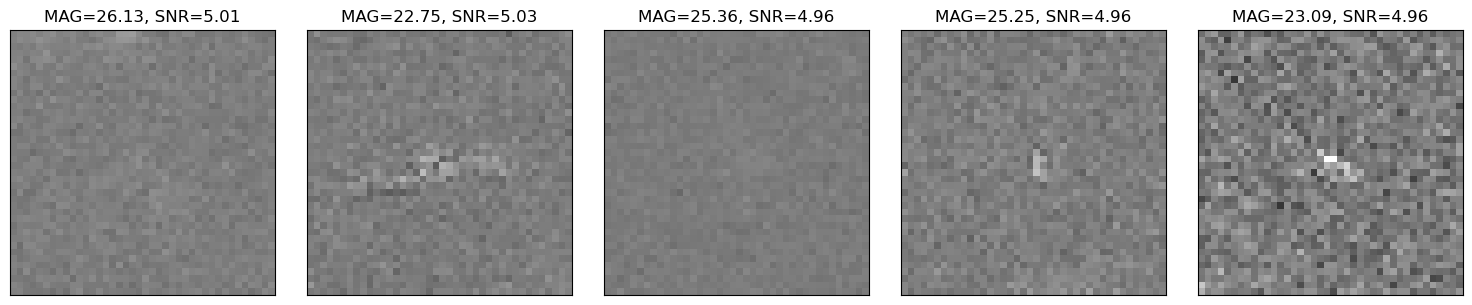

In [49]:
cutouts_of_one_snr (repo_path, collection, sources, snr=5)

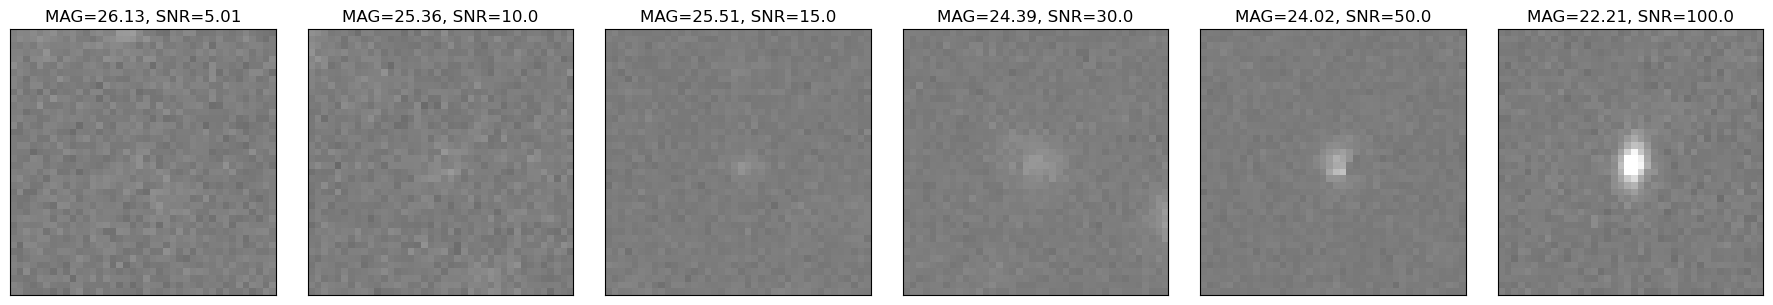

In [50]:
cutouts_by_snr_bins (repo_path, collection, sources, snr=[5, 10, 15, 30, 50, 100])

Text(0.5, 0, 'Magnitude')

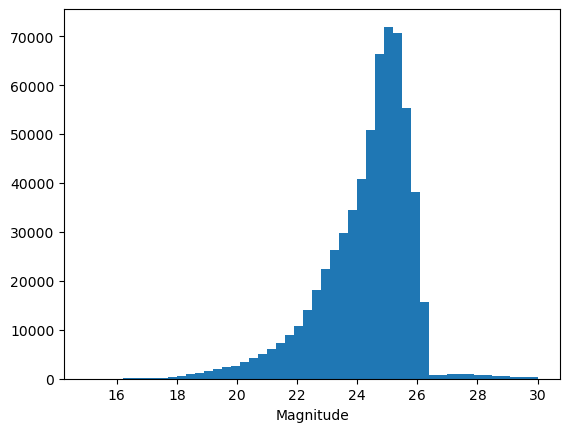

In [236]:
fig, ax = plt.subplots()
ax.hist(sources["magnitude"], bins=50, range=(15, 30))
ax.set_xlabel("Magnitude")

Text(0, 0.5, 'SNR')

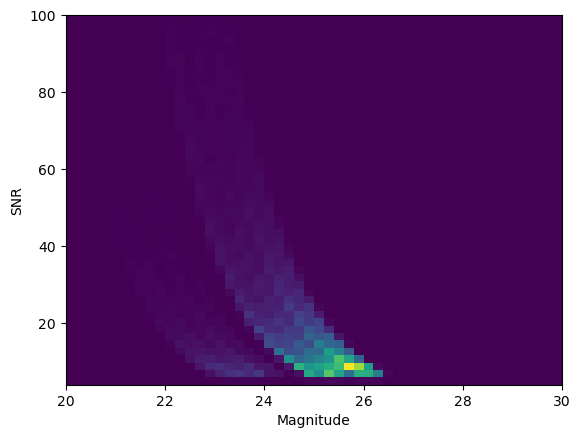

In [81]:
fig, ax = plt.subplots()
ax.hist2d(sources["magnitude"], sources["snr"], bins=50, range=[[20, 30], [4, 100]])
ax.set_xlabel("Magnitude")
ax.set_ylabel("SNR")

In [52]:
butler = Butler(repo_path)
calexp_ref = np.unique(np.array(list(butler.registry.queryDatasets("calexp",
                                                                   collections=collection,
                                                                   instrument='HSC',
                                                                   findFirst=True))))
calexp = butler.get("calexp",
                    dataId=calexp_ref[0].dataId,
                    collections=collection)
exposureTime = calexp.info.getVisitInfo().exposureTime
m5 = calexp.info.getSummaryStats().zeroPoint-2.5*np.log10(5)

In [53]:
calexp.info.getSummaryStats().zeroPoint-2.5*np.log10(5)

29.938016968356198